# PLAN

- [x] Acquisition
    - [x] Select what list of repos to scrape.
    - [x] Get requests from the site.
    - [x] Save responses to csv.
- [x] Preparation
    - [x] Prepare the data for analysis.
- [ ] Exploration
    - [ ] Answer the following prompts:
        - [x] What are the most common words in READMEs?
        - [ ] What does the distribution of IDFs look like for the most common words? - Jason
        - [ ] Does the length of the README vary by language? - Chad
        - [ ] Do different languages use a different number of unique words? DD
- [ ] Modeling
    - [ ] Transform the data for machine learning; use language to predict.
    - [ ] Fit several models using different text representations.
    - [ ] Build a function that will take in the text of a README file, and makes a prediction of language.
- [ ] Delivery
    - [ ] Github repo
        - [x] This notebook.
        - [ ] Documentation within the notebook.
        - [x] README file in the repo.
        - [ ] Python scripts if applicable.
    - [ ] Google Slides
        - [ ] 1-2 slides only summarizing analysis.
        - [ ] Visualizations are labeled.
        - [ ] Geared for the general audience.
        - [ ] Share link @ readme file and/or classroom.

# ENVIRONMENT

In [1]:
import os
import sys

import pandas as pd
import re
import json
import unicodedata
import nltk
import spacy

from requests import get
from bs4 import BeautifulSoup
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

ADDITIONAL_STOPWORDS = ['readme', '\n\n\n', '-PRON-']

# ACQUIRE

In [2]:
# We have decided to search Github for "san antonio data" and scrape the results.
# https://github.com/open-austin

In [3]:
def get_github_repo(url):
    """
    This function takes a url and returns a dictionary that
    contains the content and language of the readme file.
    """
    response = get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    readme = soup.find('div', id='readme')
    language = soup.find('span', class_='lang')
    
    d = dict()
    if readme is None:
        d['readme'] = 'No readme file.'
    else:
        d['readme'] = readme.text
    if language is None:
        d['language'] = 'No language specified.'
    else:
        d['language'] = language.text
    return d

In [4]:
# # This line to test out the function.
# get_github_repo('https://github.com/open-austin/atx-citysdk-js')

In [5]:
def get_github_links(url):
    """
    This function takes in a url and returns a list of links
    that comes from each individual repo listing page.
    """
    response = get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    links = []
    for link in soup.findAll('a', itemprop='name codeRepository', attrs={'href': re.compile("^/")}):
        links.append(link.get('href'))
    return links

In [6]:
# # This line to test out the function.
# get_github_links('https://github.com/open-austin?page=3')

In [7]:
def get_all_github_links(path, num_pages):
    """
    This function takes in a url path and number of pages
    and returns a list of lists of all links.
    """
    all_links = []
    for i in range(num_pages):      # Number of pages plus one
        page = i + 1
        response = get(path + str(page))
        soup = BeautifulSoup(response.text, 'html.parser')
        all_links.append(get_github_links(path + '?page=' + str(page)))
    return all_links

In [8]:
# # This line to test out the function.
# get_all_github_links('https://github.com/open-austin', 3)

In [9]:
def traverse(o, tree_types=(list, tuple)):
    if isinstance(o, tree_types):
        for value in o:
            for subvalue in traverse(value, tree_types):
                yield subvalue
    else:
        yield o

In [10]:
def get_github_readme(url, num_pages, cache=True):
    if cache and os.path.exists('github_readme.json'):
        readme_text = json.load(open('github_readme.json'))
    else:
        data = get_all_github_links(url, num_pages)
        readme_text = []
        for value in traverse(data):
            print('https://github.com'+value)
            readme_text.append(get_github_repo('https://github.com' + value))
        json.dump(readme_text, open('github_readme.json', 'w'))
    return readme_text

In [11]:
# Bringing it all together chaining...
from pprint import pprint
corpus = get_github_readme('https://github.com/texastribune', 8, cache=True)
pprint(corpus)

[{'language': 'Dockerfile',
  'readme': '\n'
            '\n'
            '\n'
            '\n'
            '        README.md\n'
            '      \n'
            '\n'
            '\n'
            'Base images\n'
            'How to make updates:\n'
            '\n'
            'Create a new branch\n'
            "If you're adding a python dependency:\n"
            '\n'
            'Run make run-base\n'
            "Run poetry add --dev <package> (drop the --dev if it's a "
            'production\n'
            'dependency)\n'
            'For other operations see the\n'
            'poetry docs\n'
            'Maybe edit pyproject.toml by hand if necessary\n'
            'Run poetry lock\n'
            '\n'
            '\n'
            "If it's a node dependency:\n"
            '\n'
            'Run make run-dev\n'
            'Do whatever node/yarn things you people do ;-)\n'
            '\n'
            '\n'
            'Bump the version in VERSION file\n'
            'Bump vers

            'a certain period of time and then revert to an earlier well. We '
            'recommend that\n'
            'every WellType have an empty Well object that never expires to '
            'provide a sane\n'
            'fallback.\n'
            'The WellManager has a convenience method, get_current, that takes '
            'in a WellType\n'
            'name and fetches the Well associated with that WellType, has the '
            'most recent\n'
            "pub_date in the past and doesn't have an expires in the past.\n"
            '\n'
            'Using a QuerySetBackedWellView\n'
            'Wells can also be backed by a queryset which will be used as a '
            'source of\n'
            'additional content after all items have been exhausted. '
            'Currently, this is not\n'
            'configurable via the admin, but can be easily accomplished by '
            'using the\n'
            'QuerySetBackedWellView. For example, in a urls.py:\n'
          

  'readme': '\n'
            '\n'
            '\n'
            '\n'
            '        README.md\n'
            '      \n'
            '\n'
            '\n'
            'Analysis of maternal mortality data\n'
            'This repo contains data, code and analyis supporting the Texas '
            "Tribune's maternal mortality project. We used two main analysis "
            'in the story:\n'
            '\n'
            'The mortality and prenatal rates in rural counties v. urban '
            'counties in Texas for 2010-14.\n'
            'The mortality and prenatal rate for counties with at least one '
            'hospital with an obstetric bed v. those that did not have one. '
            'This was for 2014.\n'
            '\n'
            'Installation\n'
            'This project uses pipenv to manage dependencies. Once you have '
            'that set up, install the dependencies.\n'
            'pipenv install --three\n'
            'Optional: Install extensions\n'
         

            '├── grunt-build.bat\n'
            '├── grunt-dev.command\n'
            '├── grunt-dev.bat\n'
            '├── package.json\n'
            '├── README.md\n'
            '├── .editorconfig\n'
            '├── .gitignore\n'
            '├── .jshintrc\n'
            '└── .travis.yml\n'
            '\n'
            'Roadmap\n'
            "Projected roadmap for FireShell and it's subsets builds.\n"
            '\n'
            'Integrate Grunt-init to allow for initial project naming (for '
            'dynamic CSS/JS banners)\n'
            'LESS.css variant (less dir inside src), keeping Sass as default '
            'but providing Gruntfile.js setup\n'
            'AngularJS FireShell build with MVC scaffolding\n'
            'Bower as package manager\n'
            'Static HTML Includes FireShell build (emulates server-side '
            'includes)\n'
            'PHP FireShell spawning a localhost with relevant includes\n'
            'Create a Yeoman generator for FireS

            '\n'
            'Getting Started\n'
            'git clone texastribune/tedtracker\n'
            'npm install\n'
            'To update the data from the Google spreadsheet, run npm run '
            'spreadsheet/fetch. Please note –\xa0if you do not have access to '
            'that spreadsheet and/or have not been authenticated against '
            "access to Google's Drive API with the Texas Tribune's graphics "
            'app, this will not work for you. (This should only apply to those '
            'of you playing a long at home/not members of News Apps.)\n'
            "You'll then need to pull down the raw assets from S3. We don't "
            'commit images and the like.\n'
            'npm run assets/pull\n'
            'To test the site locally, run gulp serve.\n'
            'Deployment\n'
            'Always be sure to get the latest data first!\n'
            'npm run spreadsheet/fetch\n'
            'Then build the site:\n'
            'gulp\n'
       

            '\t--env=SOURCE_DB=my-prod-db \\\n'
            '\t--env=TARGET_DB=my-test-db \\\n'
            '\t--env=DB_SUBNET_GROUP=my-subnet-group \\\n'
            '\t--env=SECURITY_GROUP=sg-123456 \\\n'
            '\t--env=TARGET_PASS=mynewpassword \\\n'
            '\t--rm --entrypoint=python texastribune/aws-tools '
            '/app/refresh-db.py\n'
            '\n'
            "It assumes an AWS region of 'us-east-1' but you can override that "
            'by setting AWS_REGION\n'
            'The DB_SUBNET_GROUP is optional and only applies to instances '
            'residing in a VPC. If not provided\n'
            'the new database will not be in a VPC.\n'
            'The security group designation for VPC instances is an ID (e.g '
            "'sg-123456'), for non-VPC it's a name (e.g. 'test-db-sg')\n"
            '\n'
            '\n'},
 {'language': 'JavaScript',
  'readme': '\n'
            '\n'
            '\n'
            '\n'
            '        README.md\n'
   

            "that by the time a user's mouse is over a button, it's too late "
            'to start\n'
            "preloading that button's interaction.\n"
            'How\n'
            'jquery.aura.js works by injecting invisible helper elements on '
            'top of your\n'
            "page, and detecting when the mouse moves over it. If you're "
            'watching for mouse\n'
            "events, these helper elements shouldn't interfere because they "
            'remove\n'
            'themselves from the DOM the moment they get activated. If this '
            'script does not\n'
            'work for you, there are alternatives, see the [Prior Art] '
            'section.\n'
            'Usage\n'
            'Trigger a callback when the mouse gets within a 40 pixel box '
            'around <div id="cake"/>:\n'
            "$('#cake').aura(40, function () { alert('Remember your diet!'); "
            '});\n'
            '\n'
            'You can also specify the box 

            'updated -reverse/-sign class names to be more consistent\n'
            'deleted duplicate icons (twitter and twitter-bird)\n'
            '\n'
            '\n'
            'Version 0.5:\n'
            '\n'
            'added tt logo bug\n'
            '\n'
            '\n'
            'Version 0.4:\n'
            '\n'
            'added flexslider nav\n'
            '\n'
            '\n'
            'Version 0.3:\n'
            '\n'
            'add share-alt\n'
            'font-awesome-ize the icons\n'
            '\n'
            '\n'
            'Version 0.2:\n'
            '\n'
            'added a copy of Best and Worst game (game uses another font '
            'icon)\n'
            'added some other icons that we currently use on the site\n'
            '\n'
            '\n'
            'Version 0.1: Festival\n'
            '\n'
            '\n'
            '\n'},
 {'language': 'Python',
  'readme': '\n'
            '\n'
            '\n'
            '\n'
         

            '\n'
            'Contributing\n'
            '\n'
            'Create something awesome -- make the code better, add some '
            'functionality,\n'
            'whatever (this is the hardest part).\n'
            'Fork it\n'
            'Create a topic branch to house your changes\n'
            'Get all of your commits in the new topic branch\n'
            'Submit a pull request\n'
            '\n'
            '\n'
            'State of Project\n'
            'Armstrong is an open-source news platform that is freely '
            'available to any\n'
            'organization.  It is the result of a collaboration between the '
            'Texas Tribune\n'
            'and Bay Citizen, and a grant from the John S. and James L. '
            'Knight\n'
            'Foundation.\n'
            'To follow development, be sure to join the Google Group.\n'
            'armstrong.apps.related_content is part of the Armstrong project.  '
            "You're\n"
           

# PREPARE

In [12]:
def basic_clean(original):
    word = original.lower()
    word = unicodedata.normalize('NFKD', word)\
                                .encode('ascii', 'ignore')\
                                .decode('utf-8', 'ignore')
    word = re.sub(r"[^a-z'\s]", ' ', word)
    word = word.replace('\n',' ')
    word = word.replace('\t',' ')
    return word

def tokenize(original):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(basic_clean(original))

def stem(original):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in original.split()]
    original_stemmed = ' '.join(stems)
    return original_stemmed

def lemmatize(original):
    nlp = spacy.load('en', parse=True, tag=True, entity=True)
    doc = nlp(original) # process the text with spacy
    lemmas = [word.lemma_ for word in doc]
    original_lemmatized = ' '.join(lemmas)
    return original_lemmatized

def remove_stopwords(original, extra_words=['readmemd'], exclude_words=[]):
    tokenizer = ToktokTokenizer()

    stopword_list = stopwords.words('english') + ADDITIONAL_STOPWORDS

    for word in extra_words:
        stopword_list.append(word)
    for word in exclude_words:
        stopword_list.remove(word)

    words = original.split()
    filtered_words = [w for w in words if w not in stopword_list]

    print('Removed {} stopwords'.format(len(words) - len(filtered_words)))
    print('---')

    original_nostop = ' '.join(filtered_words)

    return original_nostop

def prep_article(article):

#    article_stemmed = stem(basic_clean(article['readme']))
#    Note the stem line immediately above has been commented out,
#    the first item below retains the same name as the stem line above, to make everything else work.
    article_stemmed = basic_clean(article['readme'])
    article_lemmatized = lemmatize(article_stemmed)
    article_without_stopwords = remove_stopwords(article_lemmatized)
    
    article['stemmed'] = article_stemmed
    article['lemmatized'] = article_lemmatized
    article['clean'] = article_without_stopwords
    
    return article

def prepare_article_data(corpus):
    transformed  = []
    for article in corpus:
        transformed.append(prep_article(article))
    return transformed

# This is to fix the string as list of words per readme file glitch
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', ' ', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [13]:
df = pd.DataFrame(prepare_article_data(corpus))
df.shape

Removed 38 stopwords
---
Removed 181 stopwords
---
Removed 1008 stopwords
---
Removed 267 stopwords
---
Removed 73 stopwords
---
Removed 17 stopwords
---
Removed 20 stopwords
---
Removed 2 stopwords
---
Removed 2 stopwords
---
Removed 1 stopwords
---
Removed 25 stopwords
---
Removed 98 stopwords
---
Removed 257 stopwords
---
Removed 1238 stopwords
---
Removed 8 stopwords
---
Removed 109 stopwords
---
Removed 543 stopwords
---
Removed 2 stopwords
---
Removed 2 stopwords
---
Removed 40 stopwords
---
Removed 507 stopwords
---
Removed 325 stopwords
---
Removed 346 stopwords
---
Removed 2 stopwords
---
Removed 35 stopwords
---
Removed 17 stopwords
---
Removed 22 stopwords
---
Removed 9 stopwords
---
Removed 30 stopwords
---
Removed 47 stopwords
---
Removed 177 stopwords
---
Removed 122 stopwords
---
Removed 50 stopwords
---
Removed 120 stopwords
---
Removed 141 stopwords
---
Removed 5 stopwords
---
Removed 172 stopwords
---
Removed 263 stopwords
---
Removed 130 stopwords
---
Removed 37 stop

(211, 5)

In [14]:
df = df[['clean', 'language']]
# remove_stopwords(df.iloc[11].clean) - ZACH'S DIAGNOSTIC TEST

In [15]:
languages = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
languages.columns = ['n', 'ratio']
languages

,n,ratio
Python,68,0.322275
JavaScript,60,0.284360
CSS,20,0.094787
No language specified.,20,0.094787
HTML,14,0.066351
Shell,13,0.061611
Makefile,5,0.023697
Dockerfile,5,0.023697
Ruby,3,0.014218
Jupyter Notebook,2,0.009479


In [16]:
# removing all rows that has 'No language specified.'
df = df[df.language != 'No language specified.']
df = df.rename(index=str, columns={"clean": "text"})

In [17]:
df.shape

(191, 2)

In [18]:
languages = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
languages.columns = ['n', 'ratio']
languages

,n,ratio
Python,68,0.356021
JavaScript,60,0.314136
CSS,20,0.104712
HTML,14,0.073298
Shell,13,0.068063
Makefile,5,0.026178
Dockerfile,5,0.026178
Ruby,3,0.015707
Jupyter Notebook,2,0.010471
CoffeeScript,1,0.005236


**DECISION POINT**

Based on results of the above language distribution, we have made the decision to focus our analysis efforts primarily on Python and JavaScript languages, which comprises 67% of the data.

In [19]:
df = df.loc[df['language'].isin(['Python', 'JavaScript'])]
df.shape

(128, 2)

In [20]:
df.head()

,text,language
1,md software collect donation nonprofit integra...,Python
2,md datum visual create tool generate scaffoldi...,JavaScript
5,md texas tribune file app app power file syste...,JavaScript
9,md thermometer,Python
10,md wall query salesforce opportunity informati...,Python


# EXPLORE

*Explore the data that you have scraped. Here are some ideas for exploration:*

- What are the most common words in READMEs?
- What does the distribution of IDFs look like for the most common words?
- Does the length of the README vary by language?
- Do different languages use a different number of unique words?

In [21]:
df2 = df
df2.head()

,text,language
1,md software collect donation nonprofit integra...,Python
2,md datum visual create tool generate scaffoldi...,JavaScript
5,md texas tribune file app app power file syste...,JavaScript
9,md thermometer,Python
10,md wall query salesforce opportunity informati...,Python


In [23]:
df2['readme_len'] = df2['text'].apply(len)
df2

,text,language,readme_len
1,md software collect donation nonprofit integra...,Python,2533
2,md datum visual create tool generate scaffoldi...,JavaScript,9528
5,md texas tribune file app app power file syste...,JavaScript,225
9,md thermometer,Python,14
10,md wall query salesforce opportunity informati...,Python,228
11,md scuole italian school public school setup p...,Python,850
14,md geoip super simple node js base deployment ...,JavaScript,86
15,md talk online comment break open source comme...,JavaScript,1204
16,rst tx salary django application generate use ...,Python,7135
18,file,Python,4


In [29]:
python_df = df[df['language'] == 'Python']
js_df = df[df['language'] == 'JavaScript']

In [70]:
python_df.readme_len.mean()

1380.3676470588234

In [71]:
js_df.readme_len.mean()

1913.7

In [73]:
js_df.readme_len.mean() - python_df.readme_len.mean()

533.3323529411766

### **ANSWER:**
*Yes, the length of README file does vary by language.  On average, README files associated with JavaScript language are 533 characters longer than Python README files.*

## Creating series of words by language:

In [32]:
python_words = clean(' '.join(df[df.language == 'Python'].text))
js_words = clean(' '.join(df[df.language == 'JavaScript'].text))
# css_words = clean(' '.join(df[df.language == 'CSS'].text))
# html_words = clean(' '.join(df[df.language == 'HTML'].text))
# shell_words = clean(' '.join(df[df.language == 'Shell'].text))
# docker_words = clean(' '.join(df[df.language == 'Docker'].text))
# maker_words = clean(' '.join(df[df.language == 'Makefile'].text))
# ruby_words = clean(' '.join(df[df.language == 'Ruby'].text))
# jupyter_words = clean(' '.join(df[df.language == 'Jupyter Notebook'].text))
# coffee_words = clean(' '.join(df[df.language == 'CoffeeScript'].text))
all_words = clean(' '.join(df.text))

In [33]:
all_freq = pd.Series(all_words).value_counts()
python_freq = pd.Series(python_words).value_counts()
js_freq = pd.Series(js_words).value_counts()
python_freq.head()

django    179
use       177
app       149
http      109
datum     104
dtype: int64

In [34]:
print(all_freq.shape)
print(python_freq.shape)
print(js_freq.shape)

(3434,)
(2292,)
(2240,)


In [35]:
word_counts = (pd.concat([python_freq, js_freq, all_freq], axis=1, sort=True)
                .set_axis(['python', 'js', 'all'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head(10)

,python,js,all
aa,1,0,1
aaabbbcccc,1,0,1
aaec,1,0,1
aaron,1,0,1
aaronson,0,2,2
abbr,3,0,3
abcdcaz,1,0,1
abcde,2,0,2
ability,1,2,3
able,7,3,10


What are the most frequently occuring words?

In [36]:
word_counts.sort_values(by='all', ascending=False).head(10)

,python,js,all
use,177,262,439
app,149,209,358
run,76,240,316
datum,104,191,295
file,84,207,291
project,63,201,264
j,37,185,222
http,109,97,206
django,179,14,193
template,82,108,190


Are there any words that uniquely identify a particular language?

In [37]:
pd.concat([word_counts[word_counts.js == 0].sort_values(by='python').tail(25),
           word_counts[word_counts.python == 0].sort_values(by='js').tail(25)])

,python,js,all
couchdb,12,0,12
gdal,13,0,13
salesforce,13,0,13
gspreadsheet,13,0,13
locking,13,0,13
buildpack,14,0,14
nexus,14,0,14
lunchbox,14,0,14
postgi,14,0,14
mail,15,0,15


Text(0.5, 1.0, 'Proportions of Languages for the 20 most common words')

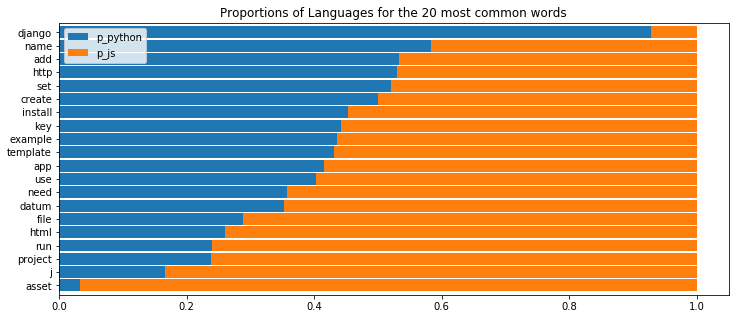

In [38]:
# figure out the percentage of language distribution
(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_js=word_counts.js / word_counts['all']
        )
 .sort_values(by='all')
 [['p_python',
   'p_js'
  ]]
 .tail(20)
 .sort_values('p_python')
 .plot.barh(stacked=True, figsize=(12,5), width=.9))

plt.title('Proportions of Languages for the 20 most common words')

In [39]:
word_counts[(word_counts.python > 10) & (word_counts.js > 10)]\
    .assign(ratio=lambda df: df.python / df.js)\
    .sort_values(by='ratio')

,python,js,all,ratio
deploy,16,99,115,0.161616
config,13,77,90,0.168831
script,20,108,128,0.185185
j,37,185,222,0.200000
pull,11,52,63,0.211538
command,19,76,95,0.250000
update,13,51,64,0.254902
build,27,105,132,0.257143
google,26,100,126,0.260000
event,15,51,66,0.294118


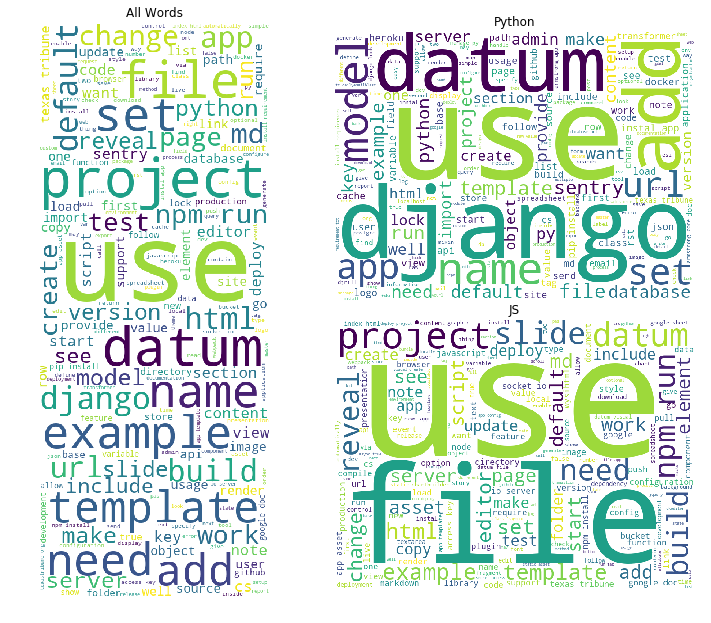

In [40]:
all_cloud = WordCloud(background_color='white', height=1000, width=400, random_state=123).generate(' '.join(all_words))
python_cloud = WordCloud(background_color='white', height=600, width=800, random_state=123).generate(' '.join(python_words))
js_cloud = WordCloud(background_color='white', height=600, width=800, random_state=123).generate(' '.join(js_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(python_cloud)
axs[2].imshow(js_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Python')
axs[2].set_title('JS')

for ax in axs: ax.axis('off')

In [41]:
top_20_python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams.head()

(instal, app)       36
(pip, install)      34
(texas, tribune)    24
(http, www)         23
(manage, py)        23
dtype: int64

In [42]:
top_20_js_bigrams = (pd.Series(nltk.ngrams(js_words, 2))
                      .value_counts()
                      .head(20))

top_20_js_bigrams.head()

(npm, run)        89
(reveal, j)       43
(google, doc)     40
(npm, install)    36
(socket, io)      35
dtype: int64

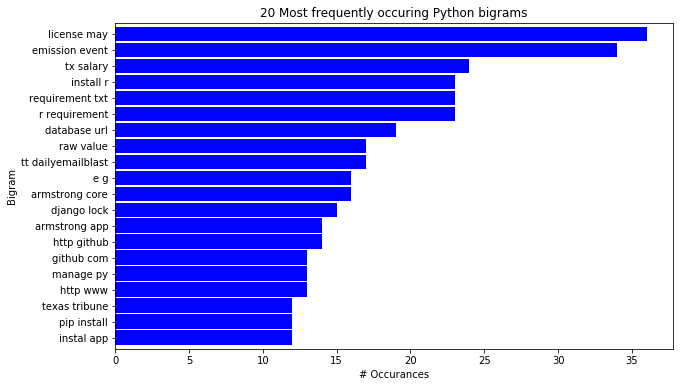

In [43]:
top_20_python_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Python bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

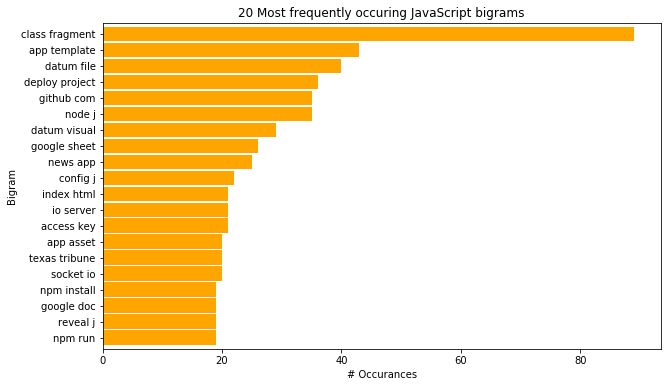

In [44]:
top_20_js_bigrams.sort_values().plot.barh(color='orange', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring JavaScript bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_js_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

Text(0.5, 1.0, 'Top 20 Python Bigrams')

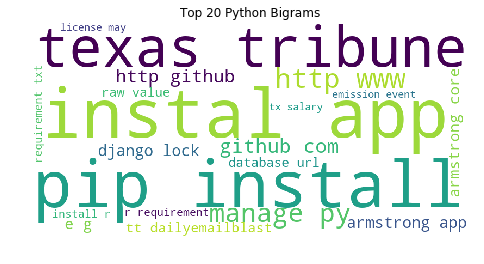

In [45]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_python_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400, random_state=123).generate_from_frequencies(data)

plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.title('Top 20 Python Bigrams')

Text(0.5, 1.0, 'Top 20 JavaScript Bigrams')

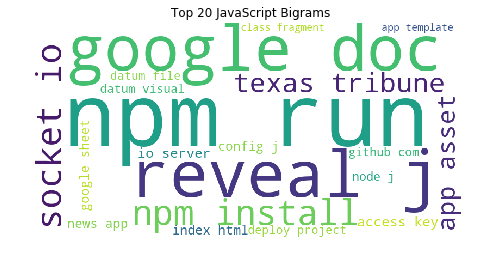

In [46]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_js_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400, random_state=123).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.title('Top 20 JavaScript Bigrams')

# MODEL

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [48]:
monkey = df
monkey['readme_len'] = monkey['text'].apply(len)
monkey
#monkey['text'].apply(len)

,text,language,readme_len
1,md software collect donation nonprofit integra...,Python,2533
2,md datum visual create tool generate scaffoldi...,JavaScript,9528
5,md texas tribune file app app power file syste...,JavaScript,225
9,md thermometer,Python,14
10,md wall query salesforce opportunity informati...,Python,228
11,md scuole italian school public school setup p...,Python,850
14,md geoip super simple node js base deployment ...,JavaScript,86
15,md talk online comment break open source comme...,JavaScript,1204
16,rst tx salary django application generate use ...,Python,7135
18,file,Python,4


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

### 1.  K-Nearest_Neighbors model

In [50]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(monkey.text)
y = monkey.language

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state = 123)

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_train)
y_pred_proba = knn.predict_proba(X_train)

In [52]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.83


In [53]:
print('Accuracy: {:.2%}'.format(knn.score(X_train, y_train)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(y_train, y_pred))
print('---')
print(classification_report(y_train, y_pred))

Accuracy: 83.15%
---
Confusion Matrix
col_0       JavaScript  Python
language                      
JavaScript          39       0
Python              15      35
---
              precision    recall  f1-score   support

  JavaScript       0.72      1.00      0.84        39
      Python       1.00      0.70      0.82        50

   micro avg       0.83      0.83      0.83        89
   macro avg       0.86      0.85      0.83        89
weighted avg       0.88      0.83      0.83        89



- **Precision:** the higher this number is, the more you were able to pinpoint all positives correctly.  If this is a low score, you predicted a lot of positives where there were none.
    - tp / (tp + fp)


- **Recall:** if this score is high, you didn’t miss a lot of positives. But as it gets lower, you are not predicting the positives that are actually there.
    - tp / (tp + fn)


- **f1-score:** The balanced harmonic mean of Recall and Precision, giving both metrics equal weight. The higher the F-Measure is, the better.


- **Support:** number of occurrences of each class in where y is true.

In [54]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.64


([<matplotlib.axis.XTick at 0x1a264deb00>,
 <a list of 5 Text xticklabel objects>)

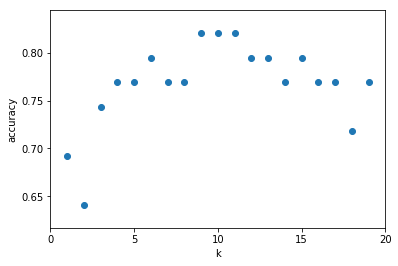

In [55]:
import matplotlib.pyplot as plt
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

### 2.  Decision Tree model

#### Split the data

In [56]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(monkey.text)
y = monkey.language

#### Train Model
- *Create the Decision Tree Object*
- *Fit the model to the training data*

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state = 123)

clf = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=123)

clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

- *Estimate language*

In [58]:
y_pred = clf.predict(X_train)
y_pred[0:5]

array(['Python', 'Python', 'Python', 'Python', 'JavaScript'], dtype=object)

- *Estimate the probability of a species*

In [59]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.81081081, 0.18918919]])

#### Evaluate Model
- *Compute the Accuracy*
- *Accuracy:  number of correct predictions over the number of total instances that have been evaluated.*

In [60]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.88


#### Create a confusion matrix
- **True Positive:** number of occurrences where y is true and y is predicted true.
- **True Negative:** number of occurrences where y is false and y is predicted false.
- **False Positive:** number of occurrences where y is false and y is predicted true.
- **False Negative:** number of occurrences where y is true and y is predicted false.

In [61]:
confusion_matrix(y_train, y_pred)

array([[31,  2],
       [ 7, 36]])

In [62]:
y_train.value_counts()

Python        43
JavaScript    33
Name: language, dtype: int64

In [63]:
import pandas as pd
labels = sorted(y_train.unique())

In [64]:
pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,JavaScript,Python
JavaScript,31,2
Python,7,36


In [65]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

  JavaScript       0.82      0.94      0.87        33
      Python       0.95      0.84      0.89        43

   micro avg       0.88      0.88      0.88        76
   macro avg       0.88      0.89      0.88        76
weighted avg       0.89      0.88      0.88        76



- **Precision:** the higher this number is, the more you were able to pinpoint all positives correctly.  If this is a low score, you predicted a lot of positives where there were none.
    - tp / (tp + fp)


- **Recall:** if this score is high, you didn’t miss a lot of positives. But as it gets lower, you are not predicting the positives that are actually there.
    - tp / (tp + fn)


- **f1-score:** The balanced harmonic mean of Recall and Precision, giving both metrics equal weight. The higher the F-Measure is, the better.


- **Support:** number of occurrences of each class in where y is true.

In [66]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.69


## 3. Logistic Regression

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [76]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.language, random_state=123)

In [77]:
tfidf = TfidfVectorizer()
tfidf.fit(X_train)
train_tfidf_values = tfidf.transform(X_train)

In [78]:
model = LogisticRegression()
model.fit(train_tfidf_values, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [79]:
predictions = model.predict(train_tfidf_values)

In [80]:
df = pd.DataFrame(dict(actual=y_train, predicted=predictions))
pd.crosstab(df.predicted,df.actual)

actual,JavaScript,Python
predicted,,
JavaScript,42,3
Python,1,50


In [81]:
from sklearn.metrics import classification_report
print(classification_report(df.actual, df.predicted))

              precision    recall  f1-score   support

  JavaScript       0.93      0.98      0.95        43
      Python       0.98      0.94      0.96        53

   micro avg       0.96      0.96      0.96        96
   macro avg       0.96      0.96      0.96        96
weighted avg       0.96      0.96      0.96        96



#### Now use the model on the test data

In [144]:
test_tfidf_values = tfidf.transform(X_test)
test_predictions = model.predict(test_tfidf_values)
print('Accuracy: {:.2%}'.format(accuracy_score(df.predicted, df.actual)))
print(classification_report(y_test, test_predictions))

Accuracy: 95.83%
              precision    recall  f1-score   support

  JavaScript       0.92      0.71      0.80        17
      Python       0.74      0.93      0.82        15

   micro avg       0.81      0.81      0.81        32
   macro avg       0.83      0.82      0.81        32
weighted avg       0.84      0.81      0.81        32



- **Precision:** the higher this number is, the more you were able to pinpoint all positives correctly.  If this is a low score, you predicted a lot of positives where there were none.
    - tp / (tp + fp)


- **Recall:** if this score is high, you didn’t miss a lot of positives. But as it gets lower, you are not predicting the positives that are actually there.
    - tp / (tp + fn)


- **f1-score:** The balanced harmonic mean of Recall and Precision, giving both metrics equal weight. The higher the F-Measure is, the better.


- **Support:** number of occurrences of each class in where y is true.

In [83]:
def predict(unknown_text):
    return model.predict(tfidf.transform([unknown_text]))[0]

In [137]:
predict('run')

'JavaScript'